In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
fig_scale = 1.#2./3.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time
import json

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [4]:
plt.rcParams['font.size'] = 14

In [5]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[GpuDevice(id=0), GpuDevice(id=1), GpuDevice(id=2), GpuDevice(id=3)]


# Process Data

In [6]:
c_df, r_df, d_df = transform.IRD(min_confirmed=0, min_recovered=0, min_deaths=20)
d_df.columns = pd.to_datetime(d_df.columns)

[265, 252, 91]


In [7]:
d_df

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,30,30,30,33,36,36,40,42,43,47
Albania,0,0,0,0,0,0,0,0,0,0,...,26,26,26,26,26,26,27,27,27,27
Algeria,0,0,0,0,0,0,0,0,0,0,...,348,364,367,375,384,392,402,407,415,419
Andorra,0,0,0,0,0,0,0,0,0,0,...,33,35,35,36,37,37,37,37,40,40
Argentina,0,0,0,0,0,0,0,0,0,0,...,115,123,129,132,136,147,152,165,176,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US,0,0,0,0,0,0,0,0,0,0,...,32930,36787,38664,40661,42094,44444,46622,49954,51949,53755
Mali,0,0,0,0,0,0,0,0,0,0,...,13,13,13,14,14,14,17,21,21,21
Australia,0,0,0,0,0,0,0,0,0,0,...,63,66,67,67,67,67,67,75,79,80


In [8]:
tests_df = pd.read_csv('../data/test_rate/test_rate_processed.csv', index_col='Country/Region')
tests_df.columns = pd.to_datetime(tests_df.columns)

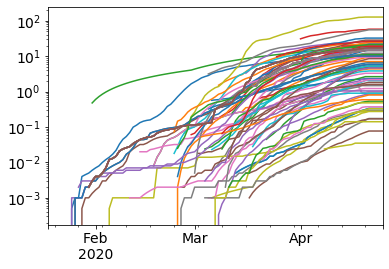

In [9]:
tests_df.T.plot(legend=False, logy=True)

In [10]:
all_countries = tests_df.index.intersection(d_df.index)

In [11]:
len(all_countries)

61

In [12]:
deaths = {}
tests = {}
start_days = np.argmax((d_df.values>3),axis=1)
end_days = np.argmax((d_df.values>1000), axis=1)
for i, country in enumerate(d_df.index):
    if country not in all_countries:
        continue
    if len(d_df.T[country].values[start_days[i]:])>10 and start_days[i]>0:
        if end_days[i]>0:
            deaths[country] = d_df[d_df.columns[start_days[i]:end_days[i]]].T[country].values
            tests[country] = tests_df[d_df.columns[start_days[i]:end_days[i]]].T[country].values
            if np.isnan(np.nanmax(tests[country])):
                del deaths[country]
                del tests[country]
        else:
            deaths[country] = d_df[d_df.columns[start_days[i]:]].T[country].values
            tests[country] = tests_df[d_df.columns[start_days[i]:]].T[country].values
            if np.isnan(np.nanmax(tests[country])):
                del deaths[country]
                del tests[country]

In [13]:
len(deaths)

56

In [14]:
samples = {}
with h5py.File('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]
countries = onp.loadtxt('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_countries.txt', 
                        delimiter='|', dtype=str)[:,0]
t0 = np.mean(samples['t0'], axis=0)
t0_dict = dict(zip(countries, t0.astype(np.int32)))

In [15]:
all_countries = list(set(deaths.keys()).intersection(countries[t0>10]))

In [16]:
len(all_countries)

44

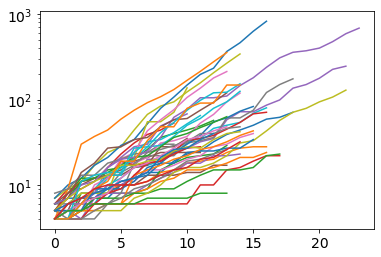

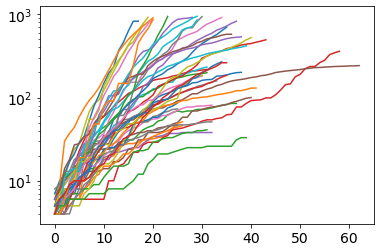

In [17]:
for c in all_countries:
    plt.semilogy(deaths[c][:t0_dict[c]])
plt.figure()
for c in all_countries:
    plt.semilogy(deaths[c])

In [18]:
with h5py.File('../data/nb_samples/4.1.1.8.4_INCL_BLOOD_MultiVariate_Regression_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[key][()]

In [19]:
all_countries = [c.decode() for c in samples['countries']]

In [20]:
len(all_countries)

40

# Bayesian Model

In [21]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(mean, std))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

In [22]:
def model():
    
    N = len(all_countries)
    
    Di = normalHP('Di', 7.0, 3.0, N)
    GR = normalHP('GR', 1.2, 0.2, N)
    alpha = numpyro.sample('alpha', dist.Normal(0.0, 0.01))

    # Create likelihood for each country    
    for i, country in enumerate(all_countries):
        dead = deaths[country][:t0_dict[country]]
        t = np.arange(len(dead))
        prediction = Di[i]*(GR[i]+alpha*np.nanmax(tests[country]))**t
        numpyro.sample(country, dist.Poisson(prediction), # Exponential regression
                       obs=dead)

In [23]:
N = len(all_countries)

scale = 0.5

init_params = {'Di_grp_mean': 7.0*np.ones((N_chains, 1)) + 3.0*scale*onp.random.randn(N_chains, 1),
               'GR_grp_mean': 1.2*np.ones((N_chains, 1)) + 0.2*scale*onp.random.randn(N_chains, 1),
               'Di_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
               'GR_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
               'Di_ind': 7.0*np.ones((N_chains, N)) + 3.0*scale*onp.random.randn(N_chains, N),
               'GR_ind': 1.2*np.ones((N_chains, N)) + 0.2*scale*onp.random.randn(N_chains, N),
               'alpha': 0.0*np.ones((N_chains, 1)) + 0.01*scale*onp.random.randn(N_chains, 1),
              }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2500, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [24]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

Time taken to compile model and draw samples : 2739.410653591156 s


In [25]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4.1.1.4.2_TESTS_Regression_samples.h5', 'w') as fp:
    for key in samples.keys():
        fp[key] = samples[key]
    fp['potential_energy'] = mcmc.get_extra_fields()['potential_energy']
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
 Di_grp_mean[0]      5.63      0.37      5.63      5.02      6.24  12384.06      1.00
Di_grp_sigma[0]      2.22      0.30      2.20      1.75      2.71  10201.98      1.00
      Di_ind[0]      8.47      0.74      8.45      7.27      9.66  12841.19      1.00
      Di_ind[1]      4.87      0.58      4.85      3.92      5.79   9002.69      1.00
      Di_ind[2]      3.80      0.61      3.77      2.81      4.81   8161.31      1.00
      Di_ind[3]      6.90      0.53      6.89      6.01      7.74   9433.90      1.00
      Di_ind[4]      3.56      0.71      3.51      2.36      4.64   8000.19      1.00
      Di_ind[5]      6.90      0.87      6.86      5.56      8.40   8943.49      1.00
      Di_ind[6]      3.32      0.63      3.27      2.27      4.30   8327.36      1.00
      Di_ind[7]      5.08      0.76      5.06      3.81      6.27  13648.68      1.00
      Di_ind[8]      4.61      0.92      4.55      3.

In [18]:
samples = {}
with h5py.File('../data/nb_samples/4.1.1.4.1_TESTS_Regression_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

In [25]:
len(all_countries)

44

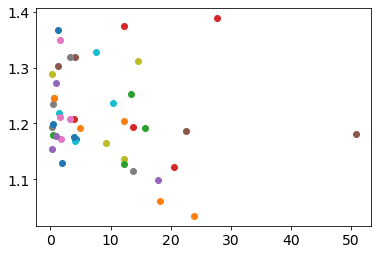

In [28]:
for i, c in enumerate(all_countries):
#     plt.plot(np.nanmax(tests[c]), np.mean(samples['GR_ind'][:,i]), 'o')
    plt.plot(np.nanmax(tests[c]), np.mean(samples['GR_ind'][:,i]+samples['alpha']*np.nanmax(tests[c])), 'o')
# plt.ylim(0, 0.6)

# Trace Plots

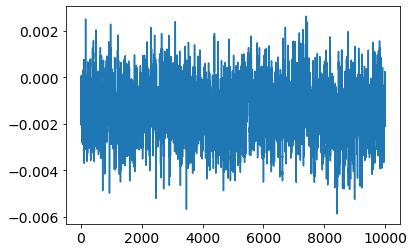

In [26]:
plt.plot(samples['alpha'])

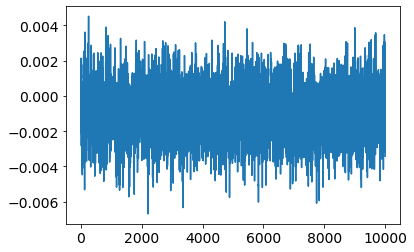

In [25]:
plt.plot(samples['alpha'])

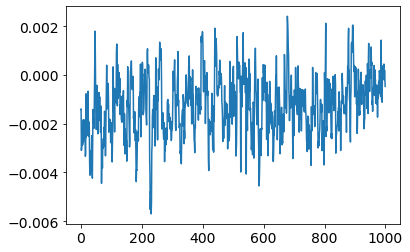

In [28]:
plt.plot(samples['alpha'])

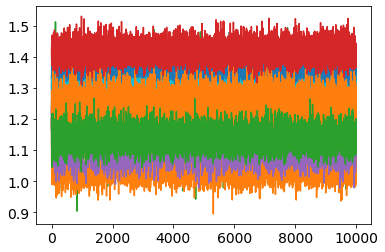

In [27]:
plt.plot(samples['GR_ind']);

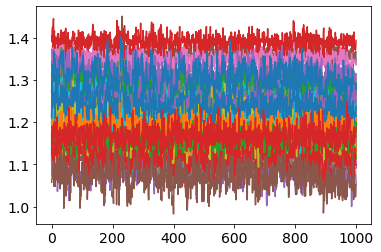

In [30]:
plt.plot(samples['GR_ind']);

In [25]:
len(t0)

78

In [26]:
2*(np.sum(t0.astype(np.int32))-(2*len(t0)+2+1))

DeviceArray(1828, dtype=int32)

# Parameter Marginals

Text(0.5, 0, 'Coefficient for Tests per 1k [per (tests/1k) per day]')

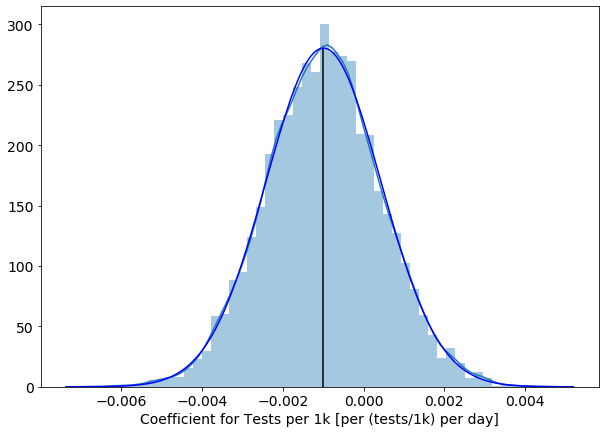

In [26]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['alpha'], bins=50, fit=norm, 
             fit_kws={'color':'blue'}, color='tab:blue', label=r'$alpha')
plt.vlines(np.mean(samples['alpha']), 0, norm.pdf(np.mean(samples['alpha']), *norm.fit(samples['alpha'])))
plt.xlabel('Coefficient for Tests per 1k [per (tests/1k) per day]')

Text(0.5, 0, 'Coefficient for Tests per 1k [per (tests/1k) per day]')

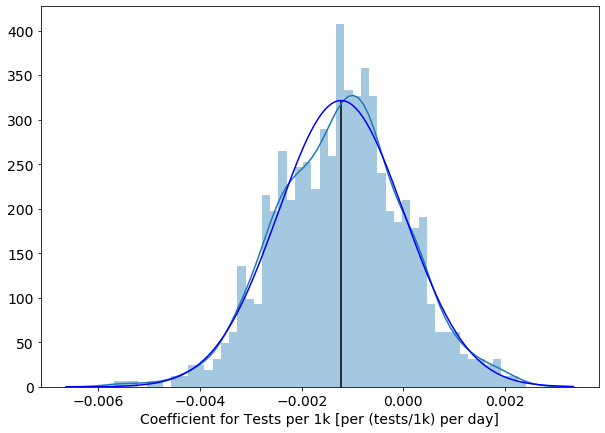

In [39]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['alpha'], bins=50, fit=norm, 
             fit_kws={'color':'blue'}, color='tab:blue', label=r'$alpha')
plt.vlines(np.mean(samples['alpha']), 0, norm.pdf(np.mean(samples['alpha']), *norm.fit(samples['alpha'])))
plt.xlabel('Coefficient for Tests per 1k [per (tests/1k) per day]')

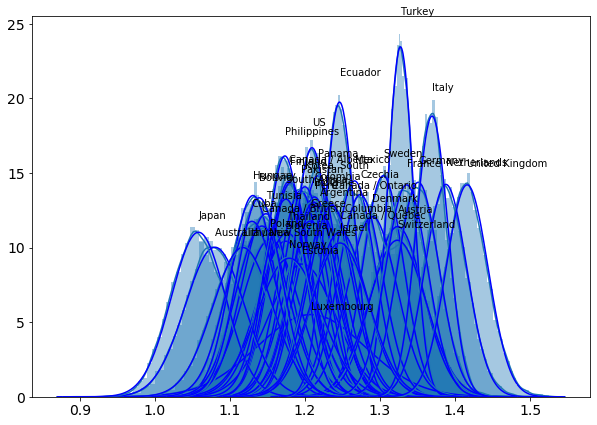

In [28]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(all_countries):
    mn = np.mean(samples['GR_ind'][:,i])
    std = np.std(samples['GR_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

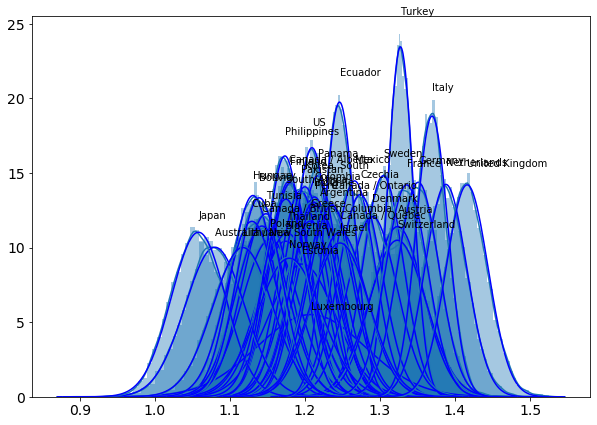

In [29]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(all_countries):
    mn = np.mean(samples['GR_ind'][:,i])
    std = np.std(samples['GR_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

# Example Plots

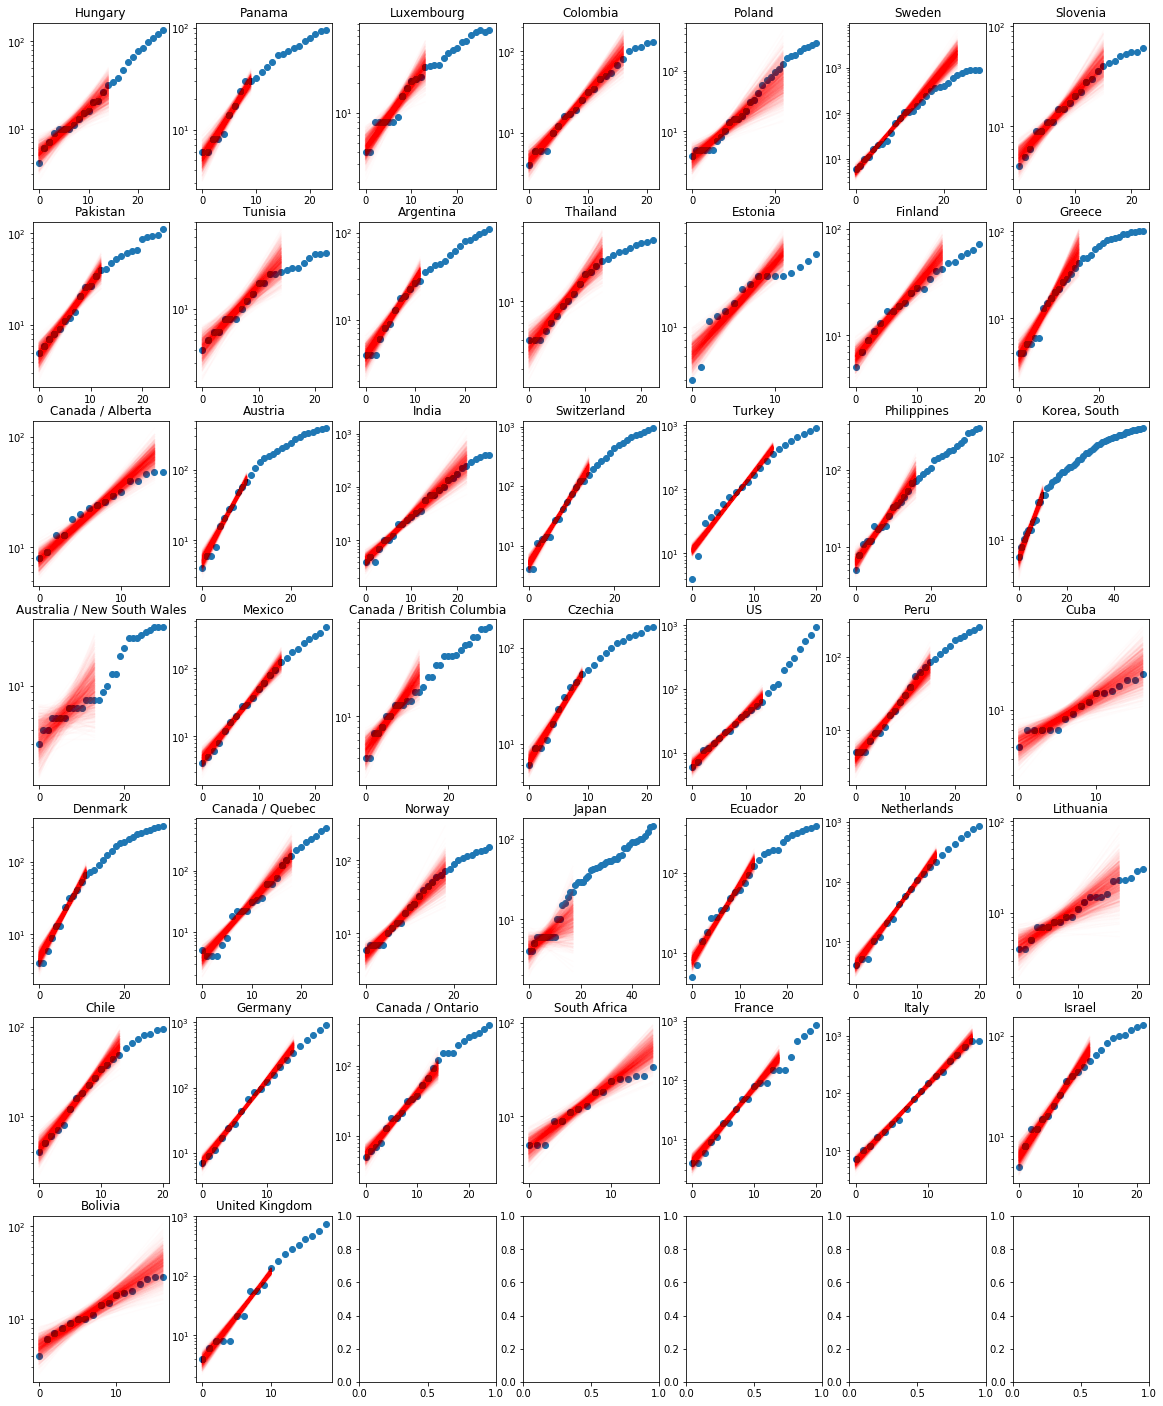

In [30]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(7, 7, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(all_countries):
    t = np.arange(len(deaths[c]))[:t0_dict[c]]
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    a[i].semilogy((samples['Di_ind'][::10,i:i+1]*(samples['GR_ind'][::10,i:i+1]+samples['alpha'][::10]*np.nanmax(tests[c]))**t[None,:]).T, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

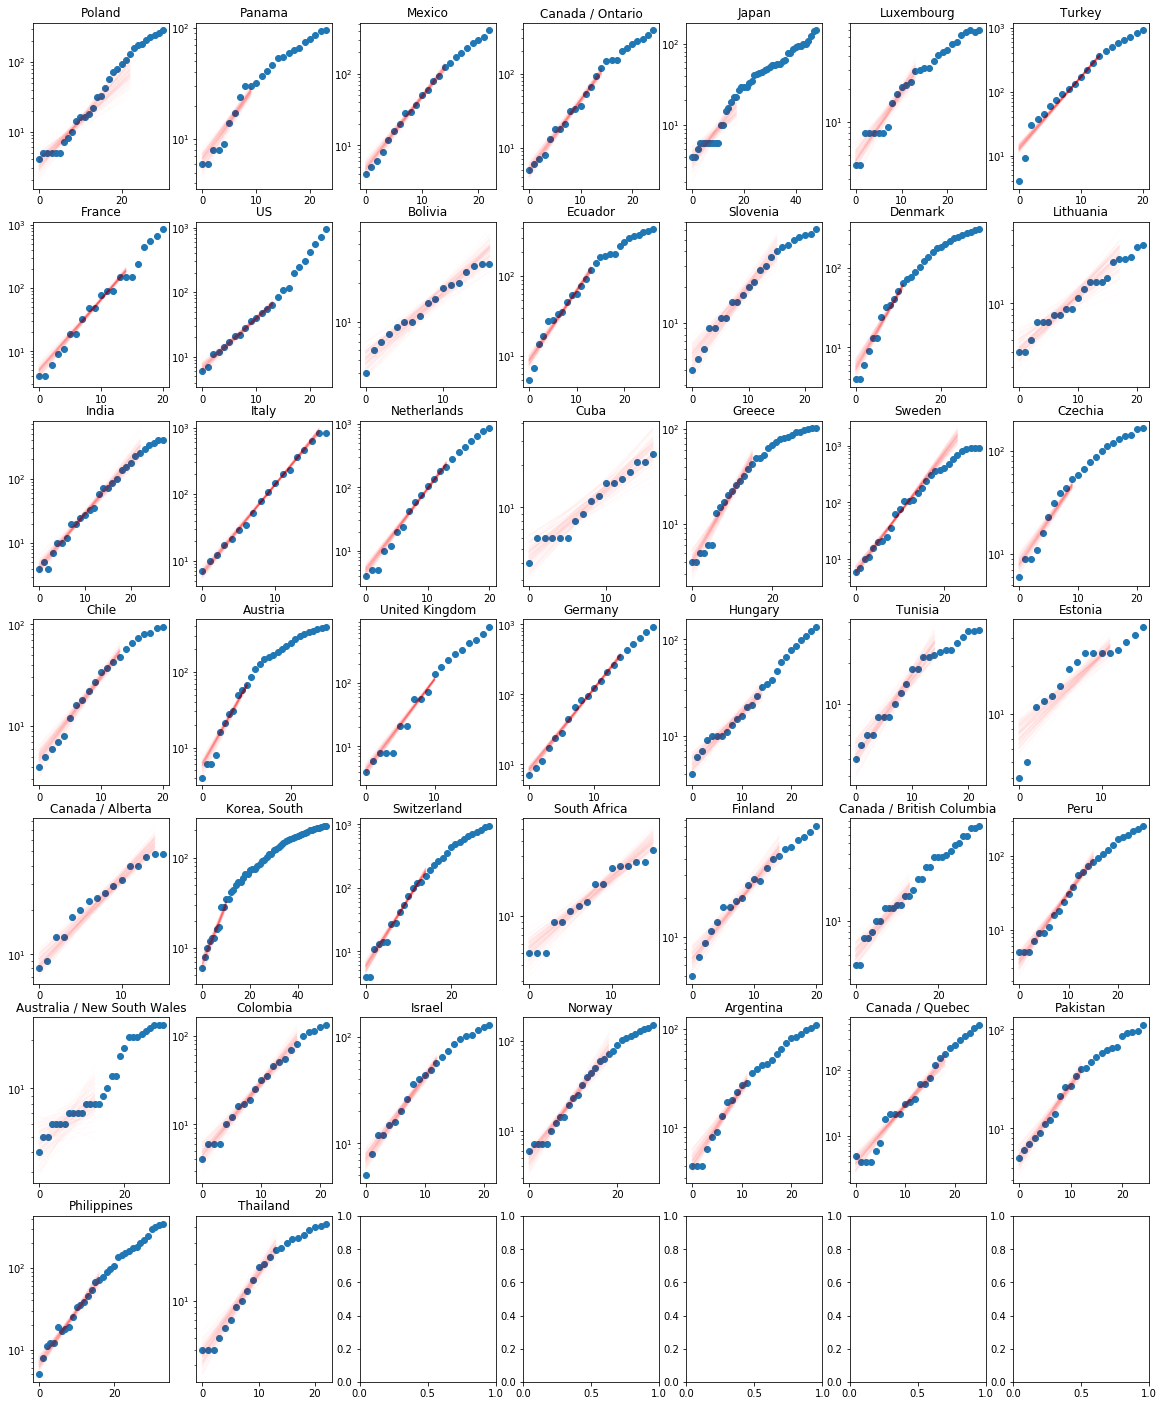

In [38]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(7, 7, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(all_countries):
    t = np.arange(len(deaths[c]))[:t0_dict[c]]
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    a[i].semilogy((samples['Di_ind'][::10,i:i+1]*(samples['GR_ind'][::10,i:i+1]+samples['alpha'][::10]*np.nanmax(tests[c]))**t[None,:]).T, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14